$$f(H^{(l)}, A) = \sigma\left( \hat{D}^{-\frac{1}{2}}\hat{A}\hat{D}^{-\frac{1}{2}}H^{(l)}W^{(l)}\right)$$

```python
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power

G = # какой-то граф на networkX в котором есть ноды, ребра и какие-то вектора признаков, ассоциированные с нодами
A = np.array(nx.attr_matrix(G, node_attr='name')[0]) # матрица смежностей
X = np.array(nx.attr_matrix(G, node_attr='name')[1])
X = np.expand_dims(X, axis=1) # матричка признаков
AX = np.dot(A, X) # скалярное произведение

# Дот продукт - это сумма по соседним узлам. Не учитывает сам узел.
# Как предлагается решить эту проблему? А просто добавить петли для каждой ноды. Таким образом каждая нода начнет ссылаться сама на себя

G_self_loops = G.copy()
self_loops = []
for i in range(G.number_of_nodes()):
    self_loops.append((i,i))
G_self_loops.add_edges_from(self_loops)
A_hat = np.array(nx.attr_matrix(G_self_loops, node_attr='name')[0]) # матрица смежностей с петлями
AX = np.dot(A_hat, X) # скалярное произведение

# Надо нормировать
# Вчисляется матрица степеней (D) и выполняется операция скалярного произведения сконвертированной D с AX (DAX). «Степень» относится к количеству ребер, с которыми связан узел.
Deg_Mat = G_self_loops.degree() # степени
D = np.diag([deg for (n, deg) in list(Deg_Mat)]) # матрица степеней с самолупами
D_inv = np.linalg.inv(D) # обратная
DAX = np.dot(D_inv, AX) # скалярное произведение

# При таком подходе, чем ниже степень у узла, тем ближе он к какому-то кластеру узлов. Решение проблемы - трюк перенормировки.
D_half_norm = fractional_matrix_power(D, -0.5)
DADX = D_half_norm.dot(A_hat).dot(D_half_norm).dot(X)

# Дальше просто: строится двухслойная сеть с прямым распространением. Четыре нейрона в первом слое. Два нейрона на выходе (два измеренеия). Relu


np.random.seed(77777)
n_h = 4 # число нейронов в скрытом слое
n_y = 2 # число нейронов на выходе
W0 = np.random.randn(X.shape[1], n_h) * 0.01
W1 = np.random.randn(n_h, n_y) * 0.01

# релу
def relu(x):
    return np.maximum(0, x)

# сеть
def gcn(A, H, W):
    I = np.identity(A.shape[0]) # диагональная матрица
    A_hat = A + I 
    D = np.diag(np.sum(A_hat, axis=0)) # матрица степеней
    D_half_norm = fractional_matrix_power(D, -0.5) # перенормировка
    eq = D_half_norm.dot(A_hat).dot(D_half_norm).dot(H).dot(W)
    return relu(eq)

# forward propagation
H1 = gcn(A, X, W0)
H2 = gcn(A, H1, W1)
```

### Zachary Karate Club

[A REVIEW : GRAPH CONVOLUTIONAL NETWORKS (GCN)](https://dsgiitr.com/blogs/gcn/)

это является частью вот этого гитхаба: 
[graph_nets](https://github.com/dsgiitr/graph_nets)

![img](img/karate_club.png)

В период с 1970 по 1972 год Уэйн В.Захари наблюдал за людьми, принадлежащими к местному клубу карате. На графе люди представлены в виде нод и ребер (связей). Затем между администратором и инструктором клуба возник конфликт и клуб раскололся. Половина участников сформировала новый клуб со старым инструктором, члены другой группы нашли нового инструктора или ушли из карате.

Захари попытался предсказать, какой член перейдет к какой половине, используя алгоритм Форда-Фалкерсона.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib notebook

import imageio
from celluloid import Camera
from IPython.display import HTML

plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

Каждый экземпляр класса GCNConv будет получать матрицу смежности в качестве входных данных и будет выводить RELU(A_hat * X * W)

Класс Net - сеть

In [2]:
class GCNConv(nn.Module):
    def __init__(self, A, in_channels, out_channels):
        super(GCNConv, self).__init__()
        self.A_hat = A + torch.eye(A.size(0))
        self.D = torch.diag(torch.sum(A, 1))
        self.D = self.D.inverse().sqrt()
        self.A_hat = torch.mm(torch.mm(self.D, self.A_hat), self.D)
        self.W = nn.Parameter(torch.rand(in_channels, out_channels, requires_grad=True))
    
    def forward(self, X):
        out = torch.relu(torch.mm(torch.mm(self.A_hat, X), self.W))
        return out

In [3]:
class Net(torch.nn.Module):
    def __init__(self,A, nfeat, nhid, nout):
        super(Net, self).__init__()
        self.conv1 = GCNConv(A, nfeat, nhid)
        self.conv2 = GCNConv(A, nhid, nout)
        
    def forward(self,X):
        H  = self.conv1(X)
        H2 = self.conv2(H)
        return H2

In [4]:
# 'A' is the adjacency matrix, it contains 1 at a position (i,j) if there is a edge between the node i and node j.
A=torch.Tensor([[0,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0],
                [1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0],
                [1,1,0,1,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0],
                [1,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1],
                [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
                [1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1],
                [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1],
                [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1],
                [0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,1],
                [0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,1,1,0,0,0,0,0,1,1,1,0,1],
                [0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,1,0,0,1,1,1,0,1,1,0,0,1,1,1,1,1,1,1,0]
                ])

В этом примере у нас есть метка для администратора (узел 1) и инструктора (узел 34), поэтому только эти два узла содержат метку класса (0 и 1), все остальные имеют значение -1, что означает, что прогнозируемое значение этих узлов будет игнорируется при вычислении функции потерь.

In [5]:
target = torch.tensor([0,-1,-1,-1, -1, -1, -1, -1,-1,-1,-1,-1, -1, -1, -1, -1,-1,-1,-1,-1, -1, -1, -1, -1,-1,-1,-1,-1, -1, -1, -1, -1, -1, 1])

X - это матрица признаков. Т.к. признаков нет, используется индекс узла

In [6]:
X = torch.eye(A.size(0))

In [7]:
X

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

Создаем сеть

In [8]:
T = Net(A, X.size(0), 10, 2)

### Training

In [9]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.SGD(T.parameters(), lr=0.01, momentum=0.9)

In [10]:
loss = criterion(T(X), target)

<IPython.core.display.Javascript object>


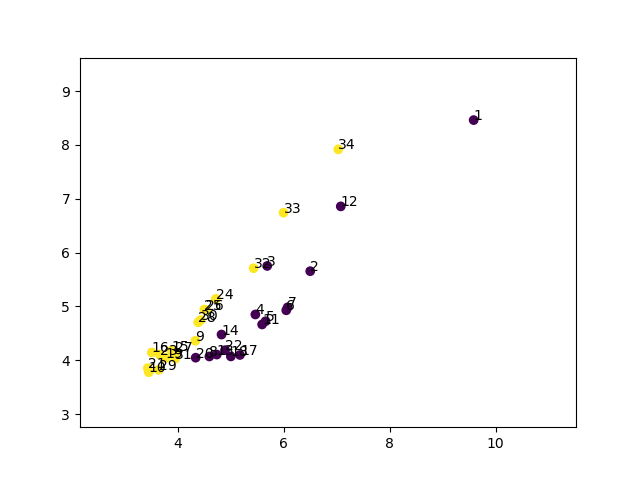

In [11]:
# Plot animation using celluloid
fig = plt.figure()
camera = Camera(fig)

for i in range(200):
    optimizer.zero_grad()
    loss = criterion(T(X), target)
    loss.backward()
    optimizer.step()
    l = (T(X));

    plt.scatter(l.detach().numpy()[:,0],l.detach().numpy()[:,1],c=[0, 0, 0, 0 ,0 ,0 ,0, 0, 1, 1, 0 ,0, 0, 0, 1 ,1 ,0 ,0 ,1, 0, 1, 0 ,1 ,1, 1, 1, 1 ,1 ,1, 1, 1, 1, 1, 1 ])
    for i in range(l.shape[0]):
        text_plot = plt.text(l[i,0], l[i,1], str(i+1))

    camera.snap()

    if i%20==0:
        print("Cross Entropy Loss: =", loss.item())

animation = camera.animate(blit=False, interval=150)
animation.save('img/train_karate_animation.mp4', writer='ffmpeg', fps=60)
HTML(animation.to_html5_video())